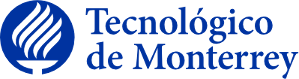

# **Maestría en Inteligencia Artificial Aplicada**

## **Proyecto Integrador - TC5035**

## Semana 3: Avance 1 - Análisis Exploratorio de Datos

### Profesores
- Dra. Grettel Barceló Alonso
- Dr. Luis Eduardo Falcón Morales

### Asesor
- Dr. Gerardo Jesús Camacho González

### Patrocinadores
- Dr. Jorge Antonio Ascencio Gutiérrez
- Yanmei King Loeza

### Equipo 29
- Carolina Lucas Dophe  –  A01702450
- Juan Pablo López Sánchez   –   A01313663
- Víctor Hugo Soto Herrera   –   A01706446

### Tabla de contenido
[Introducción](#intro)

1. [Descripción de las fuentes de datos](#fuentes)
2. [Carga de librerías y configuración inicial](#config)
3. [Carga y exploración inicial de los datos](#carga)
4. [Filtrado y limpieza de datos](#filtro)
5. [Homologación del nivel de agregación](#homologacion)
6. [Evaluación de la integración de información por variedad](#variedad)
7. [Exportación de datos](#exportacion)
8. [Análisis exploratorio de datos (EDA)](#eda)
9. [Preparación para modelado](#preparacion)
10. [Selección de enfoque de modelado](#enfoque)
11. [Análisis extendido](#extendido)

[Discusión y Conclusiones](#conclusiones)

[Referencias](#ref)

### <a class="anchor" id="intro">Introducción</a>

El presente *notebook* tiene como objetivo realizar un **análisis exploratorio de datos (EDA)** como etapa inicial del proyecto de modelado predictivo de la oferta productiva de aguacate. En esta fase se busca comprender la estructura, calidad y consistencia de los datos disponibles, así como identificar patrones generales, valores atípicos y posibles limitaciones que puedan influir en las etapas posteriores de modelado.

Dado que la **información encontrada** proviene de múltiples fuentes del SIAP, una de las primeras tareas consiste en la unificación y preparación de los datos, incluyendo la selección del cultivo y entidad de interés, la eliminación de información no relevante y la homologación de los niveles de agregación. En particular, se integrarán datos provenientes de archivos del Anuario Estadístico[[1](#ref1)] y de Datos Abiertos[[2](#ref2)], considerando variables productivas como volumen, modalidad de producción, superficie sembrada, cosechada y siniestrada, con el fin de construir un conjunto de datos consistente para el análisis.

### <a class="anchor" id="fuentes">1. Descripción de las fuentes de datos</a>

Las fuentes de datos utilizadas en este análisis corresponden a información oficial publicada por el Servicio de Información Agroalimentaria y Pesquera (SIAP), y se describen a continuación:

* **Datos Abiertos SIAP – Nivel Estado (1980–2002)**
  Conjunto de archivos anuales en formato CSV que contienen información agrícola agregada a nivel estatal, incluyendo variables productivas como superficie sembrada, superficie cosechada, volumen de producción y modalidad de producción (Riego y Temporal). Estos archivos incluyen múltiples cultivos y entidades federativas, por lo que será necesario filtrar la información correspondiente al cultivo de aguacate en el estado de Jalisco.

* **Datos Abiertos SIAP – Nivel Municipio (2003–2024)**
  Conjunto de archivos anuales en formato CSV con información desagregada a nivel municipal. Además de las variables productivas, estos archivos incluyen identificadores administrativos adicionales que no son relevantes para el alcance del proyecto. Para mantener la consistencia temporal y geográfica del análisis, esta información será agregada a nivel estatal, conservando la distinción por modalidad de producción.

* **Anuario Estadístico SIAP (1980–2024)**
  Archivo consolidado que presenta información histórica del cultivo de aguacate a nivel estatal, incluyendo variables productivas y características adicionales como la variedad del cultivo. Esta fuente se utilizará principalmente para complementar el análisis mediante información por variedad y para contextualizar la evolución productiva del cultivo a lo largo del tiempo. **`NOTA`**: la recopilación de esta información fue manual, año por año desde el sitio del Anuario Estadístico del SIAP.[[1](#ref1)]

### <a class="anchor" id="config">2. Carga de librerías y configuración inicial</a>

En esta sección se cargan las librerías necesarias para el manejo, limpieza, integración y exploración de los datos, así como algunas configuraciones básicas para facilitar la visualización y el análisis posterior.

In [ ]:
# Cargar librerías
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [ ]:
# Configuración de visualización
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:,.2f}".format)

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

In [ ]:
# Definición de rutas base
DATA_DIR = Path("data")
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"

SIAP_ABIERTOS_ESTADO_DIR = RAW_DATA_DIR / "siap_abiertos_estado"
SIAP_ABIERTOS_MUNICIPIO_DIR = RAW_DATA_DIR / "siap_abiertos_municipio"
SIAP_ANUARIO_FILE = RAW_DATA_DIR / "siap_anuario" / "anuario_aguacate.csv"

### <a class="anchor" id="carga">3. Carga y exploración inicial de los datos</a>

En esta sección se realiza una primera carga de las distintas fuentes de datos con el objetivo de entender su estructura, identificar las variables disponibles y validar la granularidad temporal y geográfica antes de aplicar cualquier proceso de limpieza o agregación.

#### 3.1 Datos Abiertos SIAP – Nivel Estado (1980–2002)

Esta subsección corresponde a los archivos de Datos Abiertos del SIAP[[2](#ref2)] que contienen información agrícola agregada a nivel estatal para el periodo 1980–2002. Cada archivo representa un año e incluye múltiples cultivos y entidades federativas.

In [ ]:
# Listar archivos disponibles (nivel estado)
estado_files = sorted(SIAP_ABIERTOS_ESTADO_DIR.glob("*.csv"))

len(estado_files), estado_files[:5]

In [ ]:
# Cargar y concatenar todos los archivos de nivel estado
df_estado_raw = pd.concat(
    (pd.read_csv(f, encoding="latin-1") for f in estado_files),
    ignore_index=True
)

df_estado_raw.shape

In [ ]:
# Mostrar las primeras filas del DataFrame
df_estado_raw.head()

In [ ]:
# Mostrar información del DataFrame
df_estado_raw.info()

#####  **`NOTA`**
- Podemos notar que existe una columna basura (`Unnamed: 18`). Después de una inspección visual, se encontraron comas al final de las líneas del archivo del año 2001. Es seguro eliminar esa columna

In [ ]:
# Eliminar columnas no nombradas
df_estado_raw = df_estado_raw.loc[:, ~df_estado_raw.columns.str.contains("^Unnamed")]

# Mostrar información del DataFrame
df_estado_raw.info()

In [ ]:
# Cultivos disponibles
df_estado_raw[
    df_estado_raw["Nomcultivo"].str.startswith("A", na=False)
]["Nomcultivo"].value_counts().head(10)

In [ ]:
# Estados disponibles
df_estado_raw["Nomestado"].value_counts().head(10)

In [ ]:
# Modalidades de producción
df_estado_raw["Nommodalidad"].value_counts()

#### 3.2 Datos Abiertos SIAP – Nivel Municipio (2003–2024)

Esta subsección corresponde a los archivos de Datos Abiertos del SIAP[[2](#ref2)] con información desagregada a nivel municipal para el periodo 2003–2024. Estos archivos incluyen identificadores administrativos adicionales que permiten mayor detalle geográfico, pero que deberán ser agregados para mantener la consistencia con los datos históricos.

In [ ]:
# Listar archivos disponibles (nivel municipio)
municipio_files = sorted(SIAP_ABIERTOS_MUNICIPIO_DIR.glob("*.csv"))

len(municipio_files), municipio_files[:5]

In [ ]:
df_municipio_raw = pd.concat(
    (pd.read_csv(f, encoding="latin-1") for f in municipio_files),
    ignore_index=True
)

df_municipio_raw.shape

#####  **`NOTA`**
Durante la exploración inicial se identificaron valores no numéricos y formatos inconsistentes en algunas variables productivas, los cuales fueron estandarizados y convertidos a valores numéricos o nulos según correspondiera, previo a la agregación de la información.

In [ ]:
# Filtrar valores no convertibles a número en Volumenproduccion
volumen_no_numerico = df_municipio_raw[
    pd.to_numeric(df_municipio_raw["Volumenproduccion"], errors="coerce").isna()
    & df_municipio_raw["Volumenproduccion"].notna()
]["Volumenproduccion"]

volumen_no_numerico.value_counts().head(10)

In [ ]:
# Reemplazar comas y convertir a numérico
df_municipio_raw["Volumenproduccion"] = (
    df_municipio_raw["Volumenproduccion"]
    .astype(str)
    .str.replace(",", "", regex=False)
)

df_municipio_raw["Volumenproduccion"] = pd.to_numeric(
    df_municipio_raw["Volumenproduccion"], errors="coerce"
)

In [ ]:
# Verificar el tipo de dato después de la conversión
df_municipio_raw["Volumenproduccion"].dtype

In [ ]:
# Filtrar valores no convertibles a número en Rendimiento
rendimiento_no_numerico = df_municipio_raw[
    pd.to_numeric(df_municipio_raw["Rendimiento"], errors="coerce").isna()
    & df_municipio_raw["Rendimiento"].notna()
]["Rendimiento"]

rendimiento_no_numerico.value_counts().head(10)

In [ ]:
# Reemplazar valores no numéricos específicos en Rendimiento
df_municipio_raw["Rendimiento"] = (
    df_municipio_raw["Rendimiento"]
    .replace("#¡NUM!", np.nan)
)

df_municipio_raw["Rendimiento"] = pd.to_numeric(
    df_municipio_raw["Rendimiento"], errors="coerce"
)

In [ ]:
# Verificar valores nulos después de la conversión
df_municipio_raw[["Volumenproduccion", "Rendimiento"]].isna().sum()

In [ ]:
# Verificar los tipos de datos finales
df_municipio_raw[["Volumenproduccion", "Rendimiento"]].dtypes

In [ ]:
# Mostrar las primeras filas del DataFrame
df_municipio_raw.head()

In [ ]:
# Mostrar información del DataFrame
df_municipio_raw.info()

#####  **`NOTAS`**
- Después de las correcciones aplicadas a las variables productivas `Volumenproduccion` y `Rendimiento`, notamos que `Sembrada` se muestra como **object**. 
- Podemos notar que hay variantes de nombres en dos columnas:
  - **Precio** también aparece como **Preciomediorural**
  - **Nomcultivo** también aparece como **Nomcultivo Sin Um**

Por este motivo es necesario revisar lo que pasa con la variable `Sembrada` y necesitamos unificar las dos variables con nombres alternos.

In [ ]:
# Mostrar las primeras filas de Sembrada
df_municipio_raw["Sembrada"].head(5)

In [ ]:
# Revisar valores no numéricos en Sembrada
pd.to_numeric(df_municipio_raw["Sembrada"], errors="coerce").isna().sum()

In [ ]:
# Reemplazar comas y convertir a numérico
df_municipio_raw["Sembrada"] = (
    df_municipio_raw["Sembrada"]
    .astype(str)
    .str.replace(",", "", regex=False)
)

df_municipio_raw["Sembrada"] = pd.to_numeric(
    df_municipio_raw["Sembrada"], errors="coerce"
)

In [ ]:
# Verificar el tipo de dato después de la conversión
df_municipio_raw["Sembrada"].dtype

In [ ]:
# Renombrar columnas para ser consistentes
column_mapping = {
    "Nomcultivo Sin Um": "Nomcultivo",
    "Preciomediorural": "Precio"
}


# Función para normalizar columnas según el mapeo dado
def normalize_columns(df, column_mapping):
    df = df.copy()
    
    for old_col, new_col in column_mapping.items():
        if old_col in df.columns:
            if new_col in df.columns:
                df[new_col] = df[new_col].fillna(df[old_col])
            else:
                df = df.rename(columns={old_col: new_col})
            df = df.drop(columns=[old_col])
    
    return df

df_municipio_raw = normalize_columns(df_municipio_raw, column_mapping)

In [ ]:
# Mostrar información del DataFrame después de las correcciones
df_municipio_raw.info()

In [ ]:
# Número de municipios distintos
df_municipio_raw["Nommunicipio"].nunique()

In [ ]:
# Modalidades de producción
df_municipio_raw["Nommodalidad"].value_counts()

#### 3.3 Anuario Estadístico SIAP

El Anuario Estadístico del SIAP[1](#ref1)] contiene información consolidada del cultivo de aguacate a nivel estatal para todo el periodo de análisis, incluyendo variables productivas y características adicionales como la variedad del cultivo.

In [ ]:
# Cargar datos del anuario, usamos UTF-8-SIG para evitar problemas con BOM
df_anuario_raw = pd.read_csv(SIAP_ANUARIO_FILE, encoding="utf-8-sig") 

df_anuario_raw.shape

In [ ]:
# Mostrar las primeras filas del DataFrame
df_anuario_raw.head()

In [ ]:
# Mostrar información del DataFrame
df_anuario_raw.info()

In [ ]:
# Mostrar conteo de variedades
df_anuario_raw["Variedad"].value_counts()

### <a class="anchor" id="filtro">4. Filtrado y limpieza de datos</a>

A partir de esta etapa, el análisis se restringe exclusivamente al cultivo de aguacate en el estado de Jalisco. Este filtrado es fundamental para asegurar la coherencia del conjunto de datos con el alcance del proyecto y evitar sesgos derivados de la inclusión de información de otros cultivos o entidades federativas.

In [ ]:
# Filtrar datos de aguacate en Jalisco (dataframe de datos a nivel estado)
df_estado = df_estado_raw.copy()

df_estado = df_estado[
    (df_estado["Nomcultivo"].str.upper() == "AGUACATE") &
    (df_estado["Nomestado"].str.upper() == "JALISCO")
]

df_estado.shape

In [ ]:
# Filtrar datos de aguacate en Jalisco (dataframe de datos a nivel municipio)
df_municipio = df_municipio_raw.copy()

df_municipio = df_municipio[
    (df_municipio["Nomcultivo"].str.upper() == "AGUACATE") &
    (df_municipio["Nomestado"].str.upper() == "JALISCO")
]

df_municipio.shape


In [ ]:
# Filtrar datos de aguacate (dataframe de datos del anuario)
# NOTA: esto no es necesario porque el anuario solo tiene datos de aguacate, pero
#       se incluye el paso en caso de que el anuario contenga otros cultivos en el futuro
df_anuario = df_anuario_raw.copy()

df_anuario = df_anuario[
    df_anuario["Nomcultivo"].str.upper() == "AGUACATE"
]

df_anuario.shape

In [ ]:
# Eliminar columnas no relevantes en df_municipio
cols_no_relevantes = [
    "Idddr", "Nomddr",
    "Idcader", "Nomcader",
    "Idmunicipio", "Nommunicipio"
]

df_municipio = df_municipio.drop(columns=cols_no_relevantes)

df_municipio.info()

In [ ]:
# Validar que solamente haya un estado y un cultivo en df_estado
df_estado["Nomestado"].unique(), df_estado["Nomcultivo"].unique()

In [ ]:
# Validar que solamente haya un estado y un cultivo en df_municipio
df_municipio["Nomestado"].unique(), df_municipio["Nomcultivo"].unique()

In [ ]:
# Validar que solamente haya un cultivo en df_anuario
df_anuario["Nomcultivo"].unique()

### <a class="anchor" id="homologacion">5. Homologación del nivel de agregación</a>

Los datos disponibles a partir de 2003 se encuentran desagregados a nivel municipal, mientras que los datos anteriores están agregados a nivel estatal. Para garantizar la consistencia temporal del conjunto de datos, es necesario agregar los registros municipales y homologarlos al nivel Estado – Año – Modalidad de producción.

#### Definición del nivel de agregación

**Claves de agrupación:**
- Anio
- Nommodalidad (Riego / Temporal)

**Variables a agregar:**
| Variable          | Operación          | Justificación                |
| ----------------- | ------------------ | ---------------------------- |
| Sembrada          | suma               | Superficie total sembrada    |
| Cosechada         | suma               | Superficie total cosechada   |
| Siniestrada       | suma               | Superficie total siniestrada |
| Volumenproduccion | suma               | Producción total             |
| Valorproduccion   | suma               | Valor económico total        |
| Rendimiento       | promedio ponderado | Depende de la superficie     |
| Precio            | promedio ponderado | Representa precio medio      |

In [ ]:
# Promedio ponderado, para columnas de rendimiento y precio 
def weighted_average(df, value_col, weight_col):
    valid = df[[value_col, weight_col]].dropna()
    if valid.empty:
        return np.nan
    return (valid[value_col] * valid[weight_col]).sum() / valid[weight_col].sum()

In [ ]:
# Agregación de datos municipales
df_municipio_agg = (
    df_municipio
    .groupby(["Anio", "Nommodalidad"])
    .apply(lambda x: pd.Series({
        "Sembrada": x["Sembrada"].sum(),
        "Cosechada": x["Cosechada"].sum(),
        "Siniestrada": x["Siniestrada"].sum(),
        "Volumenproduccion": x["Volumenproduccion"].sum(),
        "Valorproduccion": x["Valorproduccion"].sum(),
        "Rendimiento": weighted_average(x, "Rendimiento", "Cosechada"),
        "Precio": weighted_average(x, "Precio", "Volumenproduccion")
    }))
    .reset_index()
)

df_municipio_agg.head()

In [ ]:
# Preparación de datos estatales (extraer columnas relevantes)
df_estado_agg = df_estado[
    [
        "Anio", "Nommodalidad",
        "Sembrada", "Cosechada", "Siniestrada",
        "Volumenproduccion", "Valorproduccion",
        "Rendimiento", "Precio"
    ]
].copy()

df_estado_agg.head()

In [ ]:
# Unión de datos estatales y municipales
df_master = pd.concat(
    [df_estado_agg, df_municipio_agg],
    ignore_index=True
).sort_values(["Anio", "Nommodalidad"])

df_master.head()

**`NOTA`**: la columna de **año** (Anio) está siendo marcada como flotante. Posteriormente a la unión de los conjuntos de datos históricos, la variable temporal fue estandarizada a tipo entero para facilitar el análisis de series de tiempo.

In [ ]:
df_master["Anio"] = df_master["Anio"].astype(int)

df_master.head()


#####  **`NOTA`**

Para garantizar la consistencia temporal del análisis, los datos originalmente disponibles a nivel municipal fueron agregados al nivel estatal mediante sumas y promedios ponderados, utilizando como referencia la superficie cosechada y el volumen producido. De esta forma se obtuvo un conjunto de datos homogéneo por año y modalidad de producción.

### <a class="anchor" id="variedad">6. Evaluación de la integración de información por variedad</a>

Explorar la factibilidad de incorporar información desagregada por variedad de aguacate (Hass, Criollo, Sin clasificar) al conjunto de datos maestro, con el fin de enriquecer el análisis y evaluar su utilidad para el modelado predictivo.

In [ ]:
# Conteo de registros por año y variedad en el anuario
df_anuario.groupby(["Anio", "Variedad"]).size().unstack(fill_value=0)

##### **Decisión**

Aunque el Anuario Estadístico del SIAP proporciona información desagregada por variedad de aguacate, dicha información no se encuentra alineada con el nivel de modalidad de producción utilizado en el conjunto de datos principal. Por esta razón, la integración directa por variedad no se realizó, y la información fue utilizada únicamente con fines exploratorios y de análisis complementario.

Adicionalmente, el análisis exploratorio de la información por variedad muestra que, durante una parte significativa del periodo histórico (aproximadamente de 1980 a 2004), la producción de aguacate se encuentra registrada mayoritariamente bajo la categoría “Aguacate s/clasificar”, sin distinción entre variedades específicas. Esta falta de desagregación reduce sustancialmente el valor informativo de la variable `Variedad` para el análisis longitudinal y refuerza la decisión de no integrarla directamente al conjunto de datos principal.

### <a class="anchor" id="exportacion">7. Exportación de datos</a>

Una vez concluida la etapa de integración y homologación de datos, el conjunto de datos resultante fue exportado para su reutilización en las etapas posteriores de análisis exploratorio, ingeniería de características y modelado.

In [ ]:
# Guardar DataFrame maestro a CSV
df_master.to_csv(
    PROCESSED_DATA_DIR / "df_master_jalisco_aguacate_1980_2024.csv",
    index=False,
    encoding="utf-8"
)

### <a class="anchor" id="eda">8. Análisis exploratorio de datos (EDA)</a>

texto descriptivo.

In [ ]:
# Código

### <a class="anchor" id="preparacion">9. Preparación para modelado</a>

texto descriptivo.

In [ ]:
# Código

### <a class="anchor" id="enfoque">10. Selección de enfoque de modelado</a>

texto descriptivo.

In [ ]:
# Código

### <a class="anchor" id="extendido">11. Análisis extendido</a>

texto descriptivo.

In [ ]:
# En caso de que queramos agregar algún análisis extra aquí podemos hacerlo,
# por ejemplo: agregación sin modalidad, análisis de correlaciones, visualización de estacionalidad, etc.

## <a class="anchor" id="conclusiones">Conclusiones</a>

Escribir conclusiones aquí

## <a class="anchor" id="ref">Referencias</a>

[<a class="anchor" id="ref1">1</a>] Secretaría de Agricultura y Desarrollo Rural, “Cierre agrícola,” AGRICULTURA, s.f. [En línea].
Disponible en: https://nube.agricultura.gob.mx/cierre_agricola/. Accedido: 26-ene.-2026.

[<a class="anchor" id="ref2">2</a>] Secretaría de Agricultura y Desarrollo Rural, “Datos abiertos del sector agrícola,” AGRICULTURA, s.f.
[En línea]. Disponible en: https://nube.agricultura.gob.mx/datosAbiertos/Agricola.php. Accedido: 26-
ene.-2026.